#### Setting up my environment for machine learning with some common libraries.


In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scikit-learn Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, log_loss, precision_recall_curve
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.multioutput import ClassifierChain
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import label_binarize
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.cluster import DBSCAN
# SciPy Libraries
from scipy.stats import fisher_exact
from scipy.stats.mstats import winsorize

# Statsmodels Library
from statsmodels.stats.contingency_tables import mcnemar
### Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

### Data Preprocessing

##### Load the Data Set

In [2]:
# Read the SPSS file
data = pd.read_csv('Heart Failure Data.csv')  # Adjust the filename if necessary

# Print the first few rows
print(data.head())

  StudyID  Age  Sex    BMI  NYHA  HR  HTN  DM  FH  Smoker  ...  RR  \
0  MPI001   47    1  31.00     1  72    0   0   1       0  ...  16   
1  MPI002   45    1  27.55     1  68    0   0   0       0  ...  18   
2  MPI003   51    1  27.55     1  76    1   0   1       1  ...  22   
3  MPI004   51    0  25.81     1  62    0   1   0       0  ...  15   
4  MPI005   46    1  32.99     1  84    0   0   1       0  ...  20   

   Chest_pain   TC  LDLc  HDLc   TG  BNP  EuroScore  GraceScore  HF  
0           0  100    90    32   95   15          0           1   0  
1           0  110    85    34   85   18          0           1   0  
2           0  130    82    30  100   17          0           1   0  
3           0  135    75    32  120   20          0           1   0  
4           0  220   150    34  190   22          0           1   0  

[5 rows x 48 columns]


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 48 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   StudyID       500 non-null    object 
 1   Age           500 non-null    int64  
 2   Sex           500 non-null    int64  
 3   BMI           500 non-null    float64
 4   NYHA          500 non-null    int64  
 5   HR            500 non-null    int64  
 6   HTN           500 non-null    int64  
 7   DM            500 non-null    int64  
 8   FH            500 non-null    int64  
 9   Smoker        500 non-null    int64  
 10  DL            500 non-null    int64  
 11  BA            500 non-null    int64  
 12  RBS           500 non-null    float64
 13  HbA1C         500 non-null    float64
 14  Creatinine    500 non-null    float64
 15  Na            500 non-null    int64  
 16  K             500 non-null    float64
 17  Cl            500 non-null    int64  
 18  Hb            500 non-null    

### Drop unnecessary columns

In [4]:
# Drop unnecessary columns
data =data.drop(columns=['StudyID'])

#### Cheak data Shape

In [5]:
data.shape

(500, 47)

##### Cheak missing values

In [6]:
# Check for missing values
missing_values = data.isnull().sum()

# Display columns with missing values
print("Missing Values in Each Column:")
print(missing_values[missing_values > 0])

# Display the total number of missing values
total_missing = data.isnull().sum().sum()
print(f"\nTotal Missing Values in the Dataset: {total_missing}")

Missing Values in Each Column:
Series([], dtype: int64)

Total Missing Values in the Dataset: 0


#### Cheaking duplicate columns

In [7]:
# Check for duplicate columns
duplicate_columns = data.columns[data.columns.duplicated()].unique()

# Display the duplicate columns (if any)
if len(duplicate_columns) > 0:
    print(f"Duplicate columns found: {duplicate_columns}")
else:
    print("No duplicate columns found.")

No duplicate columns found.


#### Check for duplicate rows¶

In [8]:
# Check for duplicate rows
duplicate_rows = data[data.duplicated()]

# Display the duplicate rows (if any)
if not duplicate_rows.empty:
    print("Duplicate rows found:")
    print(duplicate_rows)
else:
    print("No duplicate rows found.")


No duplicate rows found.


### Outliners decetion and Removal

Which Method is Best for Heart Disease Prediction?

If the dataset is small and structured: Use IQR or Z-Score.

If the dataset has high-dimensional features: Use Isolation Forest or LOF.

If there are non-linear patterns: Use DBSCAN.

#### Plot Oulters

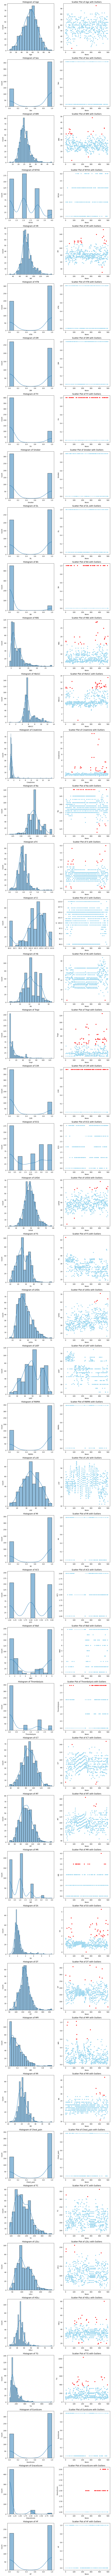

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plotting grid
num_cols = data.select_dtypes(include=[np.number]).columns
fig, axes = plt.subplots(nrows=len(num_cols), ncols=2, figsize=(10, len(num_cols)*5))

# Loop through numeric columns and plot histograms and scatter plots
for i, col in enumerate(num_cols):
    # Histogram
    sns.histplot(data[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {col}')

    # Detect outliers using IQR method
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]

    # Scatter plot with outliers in a different color
    sns.scatterplot(x=data.index, y=data[col], ax=axes[i, 1], color=['skyblue'])  # Normal points
    sns.scatterplot(x=outliers.index, y=outliers[col], ax=axes[i, 1], color='red')  # Outliers in red
    axes[i, 1].set_title(f'Scatter Plot of {col} with Outliers')

plt.tight_layout()
plt.show()


##### Remove outliers by (Density-Based Spatial Clustering of Applications with Noise) DBSCAN because non-linear patterns

In [10]:
# DBSCAN-based outlier detection
def detect_outliers_dbscan(data, eps=0.5, min_samples=5):
    numerical_data = data.select_dtypes(include=[np.number])

    # Standardize data for DBSCAN
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_data)

    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(scaled_data)

    # Identify outliers (DBSCAN labels outliers as -1)
    outliers = pd.Series(labels == -1, index=numerical_data.index)
    return outliers

# DBSCAN-based outlier detection and replacing with median
def impute_outliers_with_dbscan(data, eps=0.5, min_samples=5, max_iterations=5):
    for iteration in range(max_iterations):
        outliers = detect_outliers_dbscan(data, eps, min_samples)

        # If no outliers are found, break
        if outliers.sum() == 0:
            print(f"Outliers have been handled after {iteration + 1} iterations.")
            break

        # Replace outliers with median
        numerical_data = data.select_dtypes(include=[np.number])
        for column in numerical_data.columns:
            median_value = numerical_data[column].median()
            data.loc[outliers, column] = median_value

    return data

# Check outliers in the original dataset
outliers_before = detect_outliers_dbscan(data)
print("Outliers detected before imputation:", outliers_before.sum())

# Apply the iterative DBSCAN-based imputation method
data_imputed = impute_outliers_with_dbscan(data)

# Check outliers after imputation
outliers_after = detect_outliers_dbscan(data_imputed)
print("\nOutliers detected after iterative DBSCAN imputation:", outliers_after.sum())

# Verify if there are any outliers (should be 0)
if outliers_after.sum() == 0:
    print("\nNo outliers detected after iterative imputation.")
else:
    print("\nThere are still outliers present.")

Outliers detected before imputation: 500
Outliers have been handled after 2 iterations.

Outliers detected after iterative DBSCAN imputation: 0

No outliers detected after iterative imputation.


### Descriptive Statistics

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 47 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           500 non-null    int64  
 1   Sex           500 non-null    int64  
 2   BMI           500 non-null    float64
 3   NYHA          500 non-null    int64  
 4   HR            500 non-null    int64  
 5   HTN           500 non-null    int64  
 6   DM            500 non-null    int64  
 7   FH            500 non-null    int64  
 8   Smoker        500 non-null    int64  
 9   DL            500 non-null    int64  
 10  BA            500 non-null    int64  
 11  RBS           500 non-null    float64
 12  HbA1C         500 non-null    float64
 13  Creatinine    500 non-null    float64
 14  Na            500 non-null    int64  
 15  K             500 non-null    float64
 16  Cl            500 non-null    int64  
 17  Hb            500 non-null    float64
 18  TropI         500 non-null    

##### Summery of Statistical Numberical Colums

In [11]:
data.describe(include=[np.number]).T

,count,mean,std,min,25%,50%,75%,max
Age,500.0,56.000,0.000000e+00,56.000,56.000,56.000,56.000,56.000
Sex,500.0,1.000,0.000000e+00,1.000,1.000,1.000,1.000,1.000
BMI,500.0,24.800,7.112543e-15,24.800,24.800,24.800,24.800,24.800
NYHA,500.0,2.000,0.000000e+00,2.000,2.000,2.000,2.000,2.000
HR,500.0,78.000,0.000000e+00,78.000,78.000,78.000,78.000,78.000
HTN,500.0,1.000,0.000000e+00,1.000,1.000,1.000,1.000,1.000
DM,500.0,0.000,0.000000e+00,0.000,0.000,0.000,0.000,0.000
FH,500.0,0.000,0.000000e+00,0.000,0.000,0.000,0.000,0.000
Smoker,500.0,0.000,0.000000e+00,0.000,0.000,0.000,0.000,0.000
DL,500.0,1.000,0.000000e+00,1.000,1.000,1.000,1.000,1.000


#### Summery of Statistical catagorical Colums

In [12]:
data.describe(include=['category','object']).T

,count,unique,top,freq
BNP,500,90,20,79


#### Define the terget Variable

In [ ]:
data['HF'].unique()

In [ ]:
# Data
HF_counts = data['HF'].value_counts()
HF_percentage = HF_counts / HF_counts.sum() * 100

# Pie Chart with Shadows (Simulated 3D Effect)
plt.figure(figsize=(6, 4))
colors = ['deepskyblue','lightcoral','red','olive'][:len(HF_counts)]

plt.pie(
    HF_counts,
    labels=HF_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=[0.1] * len(HF_counts),  # Slightly separate each slice
    shadow=True  # Add shadow for depth
)
plt.title('Heart Failure (HF) Status')
plt.axis('equal')  # Ensures the pie chart is circular
plt.show()



# Bar Chart with Enhancements
fig, ax = plt.subplots(figsize=(5, 4))
colors = sns.color_palette("cool", len(HF_counts))  # Gradient color palette

bars = ax.bar(HF_counts.index, HF_counts.values, color=['deepskyblue','lightcoral','red','olive'], edgecolor='white', linewidth=1.2)

# Annotate bars
for bar, percentage in zip(bars, HF_percentage):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f'{int(bar.get_height())} ({percentage:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=10
    )

ax.set_title('Heart Failure (HF)', fontsize=14, weight='bold')
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Heart Failure (HF)', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
sns.despine()  # Remove top and right spines for a cleaner look
plt.show()

### Apply Model Without Fearures selections(or With 47 Columns)

##### Detailed encoding plan with specific numerical values

In [ ]:
import pandas as pd


# Define Encoding Methods
ordinal_features = ['NYHA', 'LVEF', 'MR', 'EuroScore', 'GraceScore']
onehot_features = ['Sex', 'Smoking', 'HTN', 'DM', 'FH', 'DL', 'BA', 'CXR', 'ECG', 'RWMA',
                   'MI', 'ACS', 'Thrombolysis','Chest_pain', 'TC', 'LDL', 'HDL', 'TG', 'BNP']
frequency_features = ['Wall']

# Assuming 'ndata' is your DataFrame and ordinal_mapping is already defined

# Apply Ordinal Encoding
for col in ordinal_features:
    if col in ndata.columns:
        ndata[col] = ndata[col].map(ordinal_mapping[col])  # Apply mapping to convert categorical to numeric

# Apply One-Hot Encoding
ndata = pd.get_dummies(ndata, columns=[col for col in onehot_features if col in ndata.columns], drop_first=True)

# Apply Frequency Encoding for High-Cardinality Variable
for col in frequency_features:
    if col in ndata.columns:
        freq_encoding = ndata[col].value_counts(normalize=True)  # Compute frequency
        ndata[col] = ndata[col].map(freq_encoding)  # Replace category with frequency

# Display first 15 rows for inspection
print(ndata.head(15).T)


### Initialize the MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Identify numerical columns (float64 type columns)
numerical_columns = ndata.select_dtypes(include=['float64']).columns

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max scaling only to the numerical columns
ndata_scaled = ndata.copy()  # Create a copy of the original dataframe
ndata_scaled[numerical_columns] = scaler.fit_transform(ndata[numerical_columns])

# Display the first few rows of the scaled DataFrame
print(ndata_scaled.head())
